## Step 1: Set up Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/EY Data Competition 2025

/content/drive/MyDrive/EY Data Competition 2025


In [ ]:
!pip install stackstac odc-stac planetary-computer rioxarray > /dev/null 2>&1


In [ ]:
################################################################################
# 1. IMPORTS & INITIAL SETUP
################################################################################

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load

# Others
import os
from tqdm import tqdm


In [ ]:
################################################################################
# 2. DEFINE AREA & TIME WINDOW
################################################################################
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
time_window = "2021-06-01/2021-09-01"

In [ ]:
################################################################################
# 3. CONNECT TO PLANETARY COMPUTER & SEARCH
################################################################################
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50}, "platform": {"in": ["landsat-8"]}}
)

items = list(search.get_items())
print('Number of Landsat-8 scenes intersecting region:', len(items))

Number of Landsat-8 scenes intersecting region: 8


In [ ]:
################################################################################
# 4. LOAD THE LANDSAT DATA
################################################################################

scale = 30 / 111320.0  # ~30m in degrees (for Landsat)

# data1: Reflective bands
data1 = stac_load(
    items,
    bands=["coastal", "green", "red","blue", "swir16", "nir08"],
    crs="EPSG:4326",  # Latitude-Longitude
    resolution=scale,  # in degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

# data2: Thermal band - e.g. "lwir11" or "ST_B10"; adapt the name if necessary
data2 = stac_load(
    items,
    bands=["lwir11"],  # or "ST_B10" or "B10" if your data keys differ
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [ ]:
display(data1)
display(data2)

<xarray.Dataset> Size: 26MB
Dimensions:      (latitude: 484, longitude: 558, time: 8)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    coastal      (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    nir08        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

<xarray.Dataset> Size: 4MB
Dimensions:      (latitude: 484, longitude: 558, time: 8)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    lwir11       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

In [ ]:
# Persist the data in memory for faster operations
data1 = data1.persist()
data2 = data2.persist()

# Scale Factors for the RGB and NIR bands
scale1 = 0.0000275
offset1 = -0.2
data1 = data1.astype(float) * scale1 + offset1

# Scale Factors for the Surface Temperature band
scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

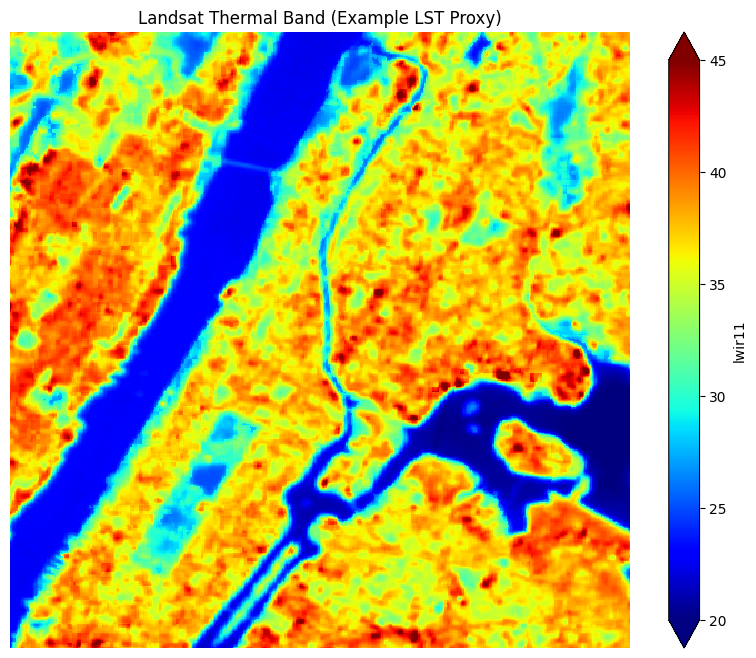

In [ ]:
################################################################################
# 5.  VISUALIZE THE THERMAL LAYER
################################################################################
scene = 2  # pick the first scene for visualization, for instance

fig, ax = plt.subplots(figsize=(10,8))
data2.isel(time=scene).lwir11.plot.imshow(
    vmin=20.0, vmax=45.0, cmap="jet", ax=ax
)
plt.title("Landsat Thermal Band (Example LST Proxy)")
plt.axis('off')
plt.show()



In [ ]:
################################################################################
# 6. EXPORT TO GEOTIFF (IF YOU WANT TO USE map_satellite_data LATER)
################################################################################
data3 = data2.isel(time=scene)
height = data3.dims["latitude"]
width  = data3.dims["longitude"]

# Create an affine transform from our bounding box
from rasterio.transform import from_bounds
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)

filename = "L8_thermal.tiff"
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True)

with rasterio.open(
    filename,
    'w',
    driver='GTiff',
    width=width,
    height=height,
    crs='epsg:4326',
    transform=gt,
    count=1,
    compress='lzw',
    dtype='float64'
) as dst:
    dst.write(data3.lwir11, 1)
    dst.close()

In [ ]:
# Show the new saved output file
!ls *.tiff

L8_reflective.tiff  L8_thermal.tiff  Landsat_LST.tiff  S2_composite_features.tiff  S2_sample.tiff


In [ ]:
################################################################################
# 7. EXAMPLE: COMBINE ALL REFLECTIVE BANDS INTO A SINGLE GEOTIFF (for mapping)
################################################################################
# Let's pick one time slice from data1 as well
data1_slice = data1.isel(time=scene)
height_ref  = data1_slice.dims["latitude"]
width_ref   = data1_slice.dims["longitude"]

filename_ref = "L8_reflective.tiff"
gt_ref = from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)

data1_slice.rio.write_crs("epsg:4326", inplace=True)
data1_slice.rio.write_transform(transform=gt_ref, inplace=True)

with rasterio.open(
    filename_ref,
    'w',
    driver='GTiff',
    width=width_ref,
    height=height_ref,
    crs='epsg:4326',
    transform=gt_ref,
    count=6,  # "coastal", "green", "red","blue", "swir16", "nir08"
    compress='lzw',
    dtype='float64'
) as dst:
    dst.write(data1_slice.coastal,   1)
    dst.write(data1_slice.green,   2)
    dst.write(data1_slice.red,   3)
    dst.write(data1_slice.blue,   4)
    dst.write(data1_slice.swir16,   5)
    dst.write(data1_slice.nir08,  6)
    dst.close()


In [ ]:
################################################################################
# 8. FUNCTION TO MAP SATELLITE DATA (BAND EXTRACTION)
################################################################################

def map_satellite_data(tiff_path, csv_path):
    """
    Reads the GeoTIFF at tiff_path and extracts band values at coordinates
    in csv_path. csv_path must have 'Latitude' and 'Longitude' columns.
    Returns a DataFrame with band columns, lat, lon.
    """
    # 1) Load the GeoTIFF
    data = rxr.open_rasterio(tiff_path)

    # 2) Read the CSV
    df_csv = pd.read_csv(csv_path)

    latitudes = df_csv['Latitude'].values
    longitudes = df_csv['Longitude'].values

    # 3) Extract each band’s value at each lat/lon
    band_count = data.rio.count
    band_values = {f"Band{i}": [] for i in range(1, band_count + 1)}

    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc=f"Mapping {tiff_path}"):
        for b in range(1, band_count + 1):
            val = data.sel(x=lon, y=lat, band=b, method="nearest").values
            band_values[f"Band{b}"].append(val)

    # 4) Create a minimal DataFrame with the new band columns + lat/lon
    reflect_df = pd.DataFrame(band_values)
    reflect_df['Latitude'] = latitudes
    reflect_df['Longitude'] = longitudes

    return reflect_df


In [ ]:
################################################################################
# 9. CREATE FINAL DATAFRAME, CALCULATE INDICES, ROUND, REORDER
################################################################################

# Example: Let "Training_data_uhi_index.csv" have [Longitude, Latitude, datetime, UHI Index]
csv_path = "Training_data_uhi_index.csv"

# (a) Reflective bands
reflect_df = map_satellite_data("L8_reflective.tiff", csv_path)

# Rename columns to actual Landsat band labels:
reflect_df.rename(
    columns={
        'Band1': 'B1',
        'Band2': 'B3',
        'Band3': 'B4',
        'Band4': 'B6',
        'Band5': 'B8',
        'Band6': 'B11'
    },
    inplace=True
)

Mapping L8_reflective.tiff: 100%|██████████| 11269/11269 [01:39<00:00, 113.50it/s]


In [ ]:
reflect_df.tail()

,B1,B3,B4,B6,B8,B11,Latitude,Longitude
11264,0.04095499999999999,0.06650250000000002,0.048765,0.043842500000000006,0.188905,0.35676500000000005,40.790333,-73.957050
11265,0.04095499999999999,0.06650250000000002,0.048765,0.043842500000000006,0.188905,0.35676500000000005,40.790308,-73.957063
11266,0.04862749999999999,0.07579750000000002,0.06488,0.05126750000000002,0.18282749999999998,0.336745,40.790270,-73.957093
11267,0.04862749999999999,0.07579750000000002,0.06488,0.05126750000000002,0.18282749999999998,0.336745,40.790253,-73.957112
11268,0.04862749999999999,0.07579750000000002,0.06488,0.05126750000000002,0.18282749999999998,0.336745,40.790237,-73.957128


In [ ]:
# (b) Thermal band => single column => rename to Temperature
thermal_df = map_satellite_data("L8_thermal.tiff", csv_path)
thermal_df.rename(columns={'Band1': 'Temperature'}, inplace=True)

# (c) Merge them on lat/lon
final_data = pd.concat(
    [reflect_df, thermal_df.drop(columns=['Latitude','Longitude'])],
    axis=1
)

# (d) Merge with original CSV for datetime & UHI Index
df_original = pd.read_csv(csv_path)  # columns: [Longitude, Latitude, datetime, UHI Index, etc.]

final_data = pd.merge(
    final_data,
    df_original[['Latitude','Longitude','datetime','UHI Index']],
    on=['Latitude','Longitude'],
    how='left'
)

# (e) Compute NDVI, NDWI, NDBI
# NDVI = (B8 - B4)/(B8 + B4)
final_data['NDVI'] = (final_data['B8'] - final_data['B4']) / (final_data['B8'] + final_data['B4'])

# NDWI = (B3 - B8)/(B3 + B8)
final_data['NDWI'] = (final_data['B3'] - final_data['B8']) / (final_data['B3'] + final_data['B8'])

# NDBI = (B11 - B8)/(B11 + B8)
final_data['NDBI'] = (final_data['B11'] - final_data['B8']) / (final_data['B11'] + final_data['B8'])

# Clean up infinities/NaN
final_data.replace([np.inf, -np.inf], np.nan, inplace=True)
final_data.dropna(subset=['NDVI','NDWI','NDBI','Temperature'], inplace=True)

# (f) Round band values to 4 decimal places
band_cols = ['B1','B3','B4','B6','B8','B11','Temperature','NDVI','NDWI','NDBI']
final_data[band_cols] = final_data[band_cols].round(4)

# (g) Reorder columns so that [Latitude, Longitude, datetime, UHI Index] come first
desired_order = [
    'Latitude',
    'Longitude',
    'datetime',
    'UHI Index'
] + band_cols  # then all band/index columns
final_data = final_data[desired_order]

print("Final data sample (after rounding, reordering):")
print(final_data.head())

Mapping L8_thermal.tiff: 100%|██████████| 11269/11269 [00:14<00:00, 786.29it/s]


Final data sample (after rounding, reordering):
    Latitude  Longitude          datetime  UHI Index                   B1  \
0  40.814292 -73.919037  24-07-2021 15:53   1.034616            0.1173225   
1  40.814365 -73.918978  24-07-2021 15:53   1.028125            0.1173225   
2  40.814433 -73.918927  24-07-2021 15:53   1.028125            0.1173225   
3  40.814500 -73.918875  24-07-2021 15:53   1.025961  0.09620250000000002   
4  40.814560 -73.918827  24-07-2021 15:53   1.025961            0.1192475   

                    B3         B4                   B6                   B8  \
0            0.1579125   0.176035  0.13296999999999998             0.204525   
1            0.1579125   0.176035  0.13296999999999998             0.204525   
2            0.1579125   0.176035  0.13296999999999998             0.204525   
3              0.13528  0.1416325  0.11344500000000002  0.18395499999999998   
4  0.18136999999999998    0.21481  0.13552750000000002             0.224105   

              

In [ ]:
final_data.head()

,Latitude,Longitude,datetime,UHI Index,B1,B3,B4,B6,B8,B11,Temperature,NDVI,NDWI,NDBI
0,40.814292,-73.919037,24-07-2021 15:53,1.034616,0.1173225,0.1579125,0.176035,0.13296999999999998,0.204525,0.19344250000000002,38.68105478000001,0.0749,-0.1286,-0.0278
1,40.814365,-73.918978,24-07-2021 15:53,1.028125,0.1173225,0.1579125,0.176035,0.13296999999999998,0.204525,0.19344250000000002,38.68105478000001,0.0749,-0.1286,-0.0278
2,40.814433,-73.918927,24-07-2021 15:53,1.028125,0.1173225,0.1579125,0.176035,0.13296999999999998,0.204525,0.19344250000000002,38.68105478000001,0.0749,-0.1286,-0.0278
3,40.814500,-73.918875,24-07-2021 15:53,1.025961,0.09620250000000002,0.13528,0.1416325,0.11344500000000002,0.18395499999999998,0.15796749999999998,38.68789082000001,0.1300,-0.1525,-0.0760
4,40.814560,-73.918827,24-07-2021 15:53,1.025961,0.1192475,0.18136999999999998,0.21481,0.13552750000000002,0.224105,0.27627250000000003,38.40419516000003,0.0212,-0.1054,0.1043


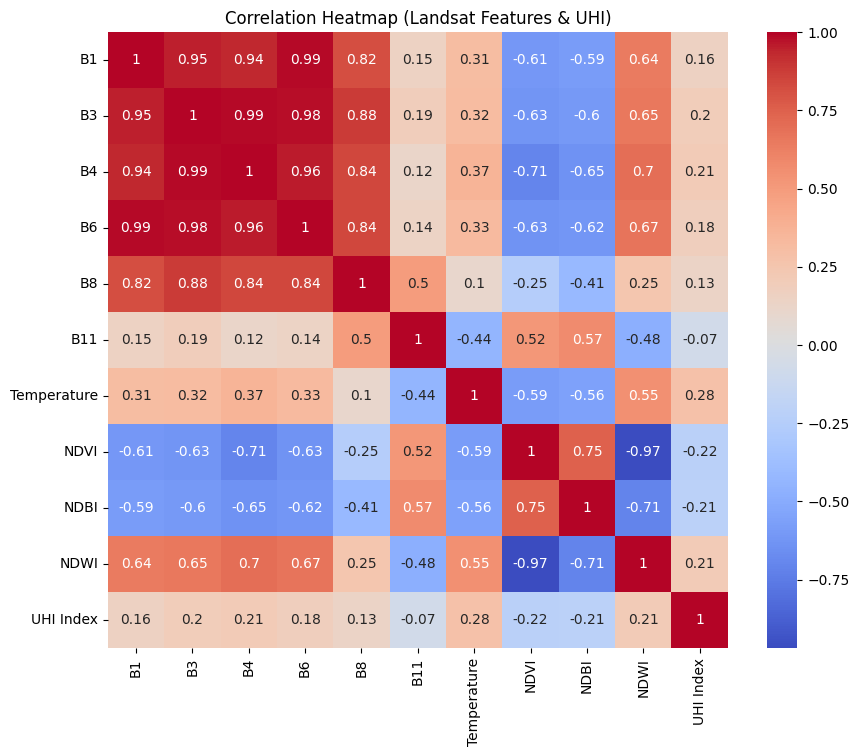

In [ ]:
################################################################################
# 10. OPTIONAL: CORRELATION MAP (UNSCALED or SCALED)
################################################################################
corr_features = ['B1','B3','B4','B6','B8','B11','Temperature','NDVI','NDBI','NDWI','UHI Index']
corr_df = final_data[corr_features].copy()

plt.figure(figsize=(10,8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Landsat Features & UHI)")
plt.show()

In [ ]:
################################################################################
# 11. TRAIN A RANDOM FOREST REGRESSOR WITH HYPER PARAMETER TUNING
################################################################################

# (a) Separate features vs. target
# We'll exclude the lat/lon/datetime from features, keep them only as reference.
feature_cols = ['B1','B3','B4','B6','B8','Temperature','NDVI','NDWI','NDBI']
X = final_data[feature_cols].values
y = final_data['UHI Index'].values

# (b) Scale features AFTER everything is in place
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# (c) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42
)

from sklearn.model_selection import GridSearchCV

# (d) Define parameter grid
param_grid = {
    'n_estimators': [50, 100 ,200],  # how many trees
    'max_depth': [None, 10, 20, 30],  # maximum depth of trees
    'min_samples_split': [2, 5],      # min samples needed to split a node
    'min_samples_leaf': [1, 2],       # min samples in a leaf
    'max_features': ['sqrt', 'log2']  # how many features considered at each split
}

# (e) Base model
rf_base = RandomForestRegressor(random_state=42)

# (f) GridSearchCV setup
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='r2',     # use R² as evaluation metric
    cv=3,             # 3-fold cross-validation
    n_jobs=-1,        # use all CPU cores for parallelism
    verbose=2         # print out progress
)

# (g) Fit grid search on training data
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV R2 score:", grid_search.best_score_)

# The best estimator (fitted already) after tuning
best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R2 score: 0.7753925848340231


In [ ]:
# Make predictions on the training data
insample_predictions= best_rf.predict(X_test)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2 = r2_score(y_test, insample_predictions)

In [ ]:
# (e) Predict & Evaluate
outsample_predictions = best_rf.predict(X_test)
r2 = r2_score(y_test, outsample_predictions)
print(f"Random Forest R² on test set: {r2:.3f}")

Random Forest R² on test set: 0.858


In [ ]:
# 1) Read your Submission template (which must have Longitude, Latitude columns)
submission_df = pd.read_csv("Submission_template.csv")
print("Submission template head:")
print(submission_df.head())

# 2) Extract reflective-band values for submission coordinates
reflect_sub = map_satellite_data("L8_reflective.tiff", "Submission_template.csv")
reflect_sub.rename(
    columns={
        'Band1': 'B1',
        'Band2': 'B3',
        'Band3': 'B4',
        'Band4': 'B6',
        'Band5': 'B8',
        'Band6': 'B11'
    },
    inplace=True
)

# 3) Extract thermal-band values for submission coordinates
thermal_sub = map_satellite_data("L8_thermal.tiff", "Submission_template.csv")
thermal_sub.rename(columns={'Band1': 'Temperature'}, inplace=True)

# 4) Combine reflective + thermal
submission_final = pd.concat(
    [reflect_sub, thermal_sub.drop(columns=['Latitude','Longitude'])],
    axis=1
)

# 5) Compute NDVI, NDWI, NDBI for submission data
submission_final['NDVI'] = (submission_final['B8'] - submission_final['B4']) / (submission_final['B8'] + submission_final['B4'])
submission_final['NDWI'] = (submission_final['B3'] - submission_final['B8']) / (submission_final['B3'] + submission_final['B8'])
submission_final['NDBI'] = (submission_final['B11'] - submission_final['B8']) / (submission_final['B11'] + submission_final['B8'])

# Replace infinities with NaN and handle if needed
submission_final.replace([np.inf, -np.inf], np.nan, inplace=True)
submission_final.fillna(0, inplace=True)  # or dropna(), depending on your workflow

# 6) Round if desired
band_cols = ['B1','B3','B4','B6','B8','Temperature','NDVI','NDWI','NDBI']
submission_final[band_cols] = submission_final[band_cols].round(4)

# 7) Prepare feature array (same columns used in training)
feature_cols = ['B1','B3','B4','B6','B8','Temperature','NDVI','NDWI','NDBI']
X_submit = submission_final[feature_cols].values

# 8) Transform using the SAME scaler as in training
X_submit_scaled = scaler.transform(X_submit)

# 9) Predict with the SAME trained model
final_predictions = best_rf.predict(X_submit_scaled)

# 10) Insert predicted UHI Index into your submission dataframe
#     If 'submission_df' has columns [Longitude, Latitude, ...], we add/overwrite "UHI Index".
submission_df["UHI Index"] = final_predictions

# 11) Reorder final columns EXACTLY as desired:
submission_df = submission_df[["Longitude", "Latitude", "UHI Index"]]

# 12) Save to CSV
submission_df.to_csv("submission.csv", index=False)

print("Final submission head:")
print(submission_df.head())


In [ ]:
submission_df.head()